# **Laplace-Redux Experiment** : Uncertainty in a image classification with a CNN

## Package installations

In [2]:
!pip install netcal laplace-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [3]:
!git clone https://github.com/aleximmer/Laplace.git

Cloning into 'Laplace'...
remote: Enumerating objects: 2905, done.
remote: Counting objects: 100% (1314/1314), done.
remote: Compressing objects: 100% (467/467), done.
remote: Total 2905 (delta 957), reused 1061 (delta 844), pack-reused 1591
Receiving objects: 100% (2905/2905), 1.63 MiB | 3.28 MiB/s, done.
Resolving deltas: 100% (2069/2069), done.


## Imports

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import torch
import torch.nn.functional as F
import torch.distributions as dists
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np
import Laplace.examples.helper.wideresnet as wrn
import Laplace.examples.helper.dataloaders as dl
from Laplace.examples.helper import util
from netcal.metrics import ECE
import matplotlib.pyplot as plt

from laplace import Laplace


np.random.seed(7777)
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

This next cell is for enabling logs


In [5]:
from importlib import reload
import logging


# doest not work for ipynb
reload(logging)
logging.basicConfig(level=logging.INFO)

# Data and model loading

For this experiment, we used the pretrained WideResNet model of the author, and the CIFAR10 dataset of images. As we needed small computation time, we chose to work with CIFAR10 instead of bigger dataset such as ImageNet. We also took advantage of the model proposed in author experiment as it is already pretrained on CIFAR10 and achieving high accuracy (~95%).

In [6]:
train_loader = dl.CIFAR10(train=True)
test_loader = dl.CIFAR10(train=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
targets = torch.cat([y for x, y in test_loader], dim=0).cpu()

# The model is a standard WideResNet 16-4
# Taken as is from https://github.com/hendrycks/outlier-exposure
model = wrn.WideResNet(16, 4, num_classes=10).cuda().eval()

util.download_pretrained_model()
model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt'))

100%|██████████| 170498071/170498071 [00:13<00:00, 12403684.37it/s]


Extracting ./temp/cifar-10-python.tar.gz to ./temp/
Files already downloaded and verified


<All keys matched successfully>

## Uncertainty prediction without Laplace Approximation

Let's pick an image in the testset to work on. We chose to use this frog picture as it is easily recognisable for human despite the low resolution of CIFAR10 images.

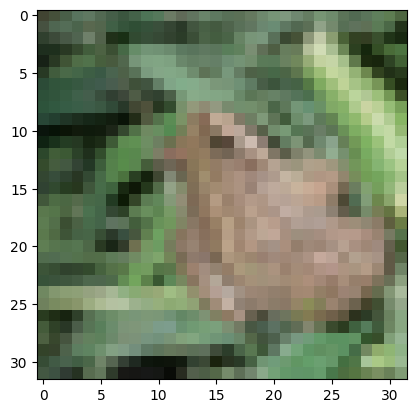

In [7]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx]
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [8]:
from prettytable import PrettyTable

def predict(model, image, classes):
    model.eval()
    probabilities = F.softmax(model(image.unsqueeze(0).cuda())).squeeze(0)
    print(f"The model predicts that the picture is a {classes[torch.argmax(probabilities)]}")
    table = PrettyTable()
    table.field_names = ["Classe", "Probabilité"]
    for i, prob in enumerate(probabilities.cpu().detach().numpy()):
        table.add_row([classes[i], f"{prob:.4f}"])
    print(table)

In [9]:
predict(model, frog_img, classes)

The model predicts that the picture is a frog
+--------+-------------+
| Classe | Probabilité |
+--------+-------------+
| plane  |    0.0000   |
|  car   |    0.0000   |
|  bird  |    0.0000   |
|  cat   |    0.0000   |
|  deer  |    0.0000   |
|  dog   |    0.0000   |
|  frog  |    1.0000   |
| horse  |    0.0000   |
|  ship  |    0.0000   |
| truck  |    0.0000   |
+--------+-------------+


We can see on the table above that, if we consider that the softmax probability vector is a prediction probability, the model is sure that it is a frog

Now we're interested in the model uncertainty in the case of an adversorial attack that noise the original image. Let's first simulate such a noise with a gaussian noise :

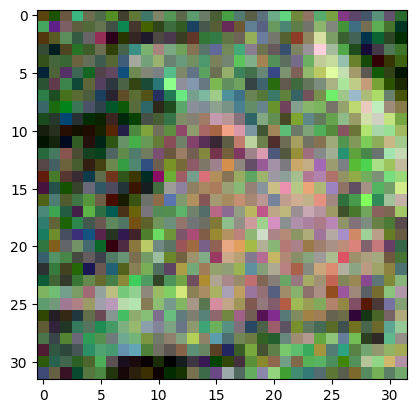

In [10]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.1*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [11]:
predict(model, frog_img, classes)

The model predicts that the picture is a cat
+--------+-------------+
| Classe | Probabilité |
+--------+-------------+
| plane  |    0.0001   |
|  car   |    0.0001   |
|  bird  |    0.1216   |
|  cat   |    0.4404   |
|  deer  |    0.3484   |
|  dog   |    0.0003   |
|  frog  |    0.0887   |
| horse  |    0.0000   |
|  ship  |    0.0003   |
| truck  |    0.0001   |
+--------+-------------+


Here we can see that the noise added is sufficient for the model getting wrong. But, following the softmax vector of probability, the model show uncertainty, as there are several values close to each other (bid, cat, deer).

Let's add more noise :

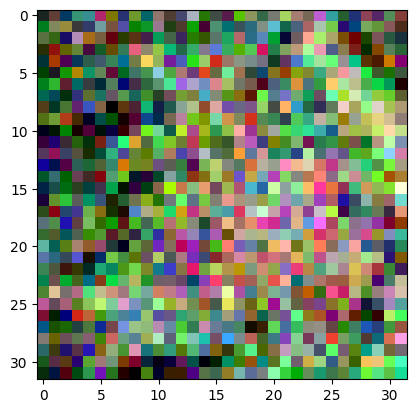

In [12]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.20*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [13]:
predict(model, frog_img, classes)

The model predicts that the picture is a cat
+--------+-------------+
| Classe | Probabilité |
+--------+-------------+
| plane  |    0.0002   |
|  car   |    0.0007   |
|  bird  |    0.3271   |
|  cat   |    0.5926   |
|  deer  |    0.0580   |
|  dog   |    0.0007   |
|  frog  |    0.0188   |
| horse  |    0.0001   |
|  ship  |    0.0011   |
| truck  |    0.0005   |
+--------+-------------+


Now we can see that, even if the image is merely not recognisable for human, the model is quite sure that it is a cat. Here the model is overconfident, telling us with more than 75% probability that the image is a cat.

If we increase again the noise and get the image totally noised, the model is more and more sure about its cat prediction.

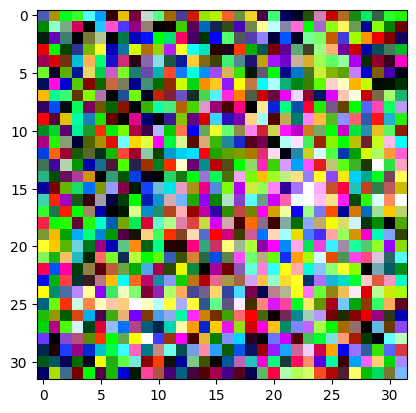

In [14]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.50*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [15]:
predict(model, frog_img, classes)

The model predicts that the picture is a cat
+--------+-------------+
| Classe | Probabilité |
+--------+-------------+
| plane  |    0.0020   |
|  car   |    0.0197   |
|  bird  |    0.0649   |
|  cat   |    0.8684   |
|  deer  |    0.0113   |
|  dog   |    0.0115   |
|  frog  |    0.0133   |
| horse  |    0.0004   |
|  ship  |    0.0007   |
| truck  |    0.0078   |
+--------+-------------+


Even if the model can't recognize an animal and is unable to classify this fully noised picture, we would like the model to show uncertainty in its prediction, such as a constant vector of probabilities (0.1, 0.1 .., 0.1). This way, we could know whether the prediction of the model is reliable or not.

## Uncertainty prediction using Laplace Approximation

The bayesian framework enables us to get another way of measuring uncertainty in a neural network. In particular, by using the Laplace Approximation to turn an already pretrained model into a partial bayesian neural network, we can efficiently compute the output and get a new measure of uncertainty.

Let's train the Laplace Approximation on the last layer of our current network as suggested in the Laplace-Redux article. By this way, the weight of the last layer of our neural network will become gaussian random variables. Then, the predictive distribution $p(y | f(x_*), D)$ in a classification task as here can be approximated by Monte Carlo method. Using these Monte Carlo samples enable us to get some variance in the prediction, and thus, provide us with another uncertainty measure.

In [16]:
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

In [142]:
def predict_la(la_model, image, classes):
    samples = la_model.predictive_samples(image.unsqueeze(0).cuda())
    probabilities = samples.mean(dim=0).squeeze(0).cpu().detach().numpy()
    std = samples.std(dim=0).squeeze(0).cpu().detach().numpy()
    print(f"The model predicts that the picture is a {classes[np.argmax(probabilities)]}")

    table = PrettyTable()
    table.field_names = ["Classe", "Probabilité +- 3*std"]
    for i, prob in enumerate(probabilities):
        table.add_row([classes[i], f"{probabilities[i]:.4f} +- {3*std[i]:.4f}"])
    print(table)

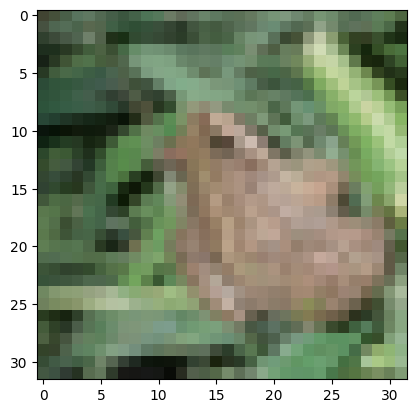

In [143]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx]
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [144]:
predict_la(la, frog_img, classes)

The model predicts that the picture is a frog
+--------+----------------------+
| Classe | Probabilité +- 3*std |
+--------+----------------------+
| plane  |   0.0000 +- 0.0000   |
|  car   |   0.0000 +- 0.0000   |
|  bird  |   0.0000 +- 0.0000   |
|  cat   |   0.0000 +- 0.0000   |
|  deer  |   0.0000 +- 0.0000   |
|  dog   |   0.0000 +- 0.0000   |
|  frog  |   1.0000 +- 0.0000   |
| horse  |   0.0000 +- 0.0000   |
|  ship  |   0.0000 +- 0.0000   |
| truck  |   0.0000 +- 0.0000   |
+--------+----------------------+


Here we can see that the model show high confidence, which is what we expect from the model. Let's add an increasing noise like we've done in the previous section :

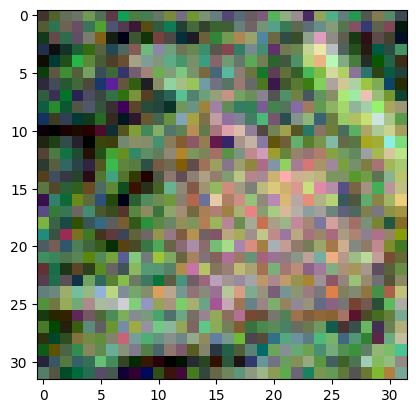

In [157]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.10*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [158]:
predict_la(la, frog_img, classes)

The model predicts that the picture is a deer
+--------+----------------------+
| Classe | Probabilité +- 3*std |
+--------+----------------------+
| plane  |   0.0001 +- 0.0006   |
|  car   |   0.0002 +- 0.0009   |
|  bird  |   0.1165 +- 0.2989   |
|  cat   |   0.2679 +- 0.4821   |
|  deer  |   0.4014 +- 0.6631   |
|  dog   |   0.0005 +- 0.0013   |
|  frog  |   0.2124 +- 0.5058   |
| horse  |   0.0000 +- 0.0002   |
|  ship  |   0.0008 +- 0.0033   |
| truck  |   0.0002 +- 0.0008   |
+--------+----------------------+


Here, the model is wrong but show a high uncertainty which can be seen through the standard deviation of the samples of probabilities we generated. Here, the predicted probability of the image being a deer is 40% and the probability of the image being a frog is 21%. But if we consider the equivalent of the 95% confidence interval for a normal distribution by considering +- 3 times the standard deviation, the model shows very high uncertainty such that the frog could be the right prediction.

$\textbf{NB :}$ Actually, this interpretation of the $3*\sigma$ confidence interval is not rigorous. The interval of probabilities it shows is sometimes outside $[0,1]$ but we used it however to get an order of magnitude of the uncertainty.

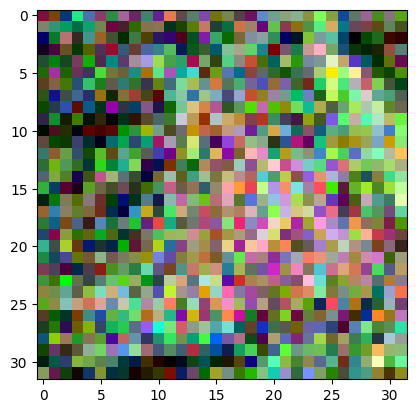

In [147]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.20*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [148]:
predict_la(la, frog_img, classes)

The model predicts that the picture is a cat
+--------+----------------------+
| Classe | Probabilité +- 3*std |
+--------+----------------------+
| plane  |   0.0004 +- 0.0014   |
|  car   |   0.0008 +- 0.0033   |
|  bird  |   0.1361 +- 0.4068   |
|  cat   |   0.5777 +- 0.6728   |
|  deer  |   0.1976 +- 0.5116   |
|  dog   |   0.0017 +- 0.0052   |
|  frog  |   0.0839 +- 0.2727   |
| horse  |   0.0001 +- 0.0005   |
|  ship  |   0.0011 +- 0.0049   |
| truck  |   0.0005 +- 0.0022   |
+--------+----------------------+


The model is also wrong, but shows less uncertainty on the frog prediction. However, the cat prediction still have a very high uncertainty which is nice since it shows the model is not reliable on this prediction.

Let's try to increase the noise one more time to see if the uncertainty increases too.

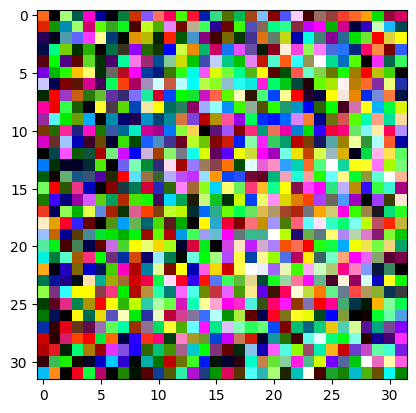

In [149]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx] + 0.50*torch.randn_like(image[image_batch_idx])
plt.imshow(frog_img.detach().cpu().transpose(0,2).numpy())

In [150]:
predict_la(la, frog_img, classes)

The model predicts that the picture is a cat
+--------+----------------------+
| Classe | Probabilité +- 3*std |
+--------+----------------------+
| plane  |   0.0040 +- 0.0128   |
|  car   |   0.0708 +- 0.2993   |
|  bird  |   0.0412 +- 0.1519   |
|  cat   |   0.7452 +- 0.5592   |
|  deer  |   0.0325 +- 0.1032   |
|  dog   |   0.0324 +- 0.1097   |
|  frog  |   0.0113 +- 0.0532   |
| horse  |   0.0021 +- 0.0096   |
|  ship  |   0.0023 +- 0.0087   |
| truck  |   0.0582 +- 0.2462   |
+--------+----------------------+


Here on the fully noised image, the model shows some uncertainty, but not enough. The cat prediction with this uncertainty could still be considered as the right prediction by only watching on the probabilities and standard deviation of the prediction.

Finally, we consider that the uncertainty prediction coming from the laplace approximation and Monte Carlo approximation of the predictive distribution can be useful, but still presents some serious issues.

# Appendix

Here we will do some data visualisation for the report.

Next plot is about showing the evolution of the standard deviation w.r.t the scale of the noise :

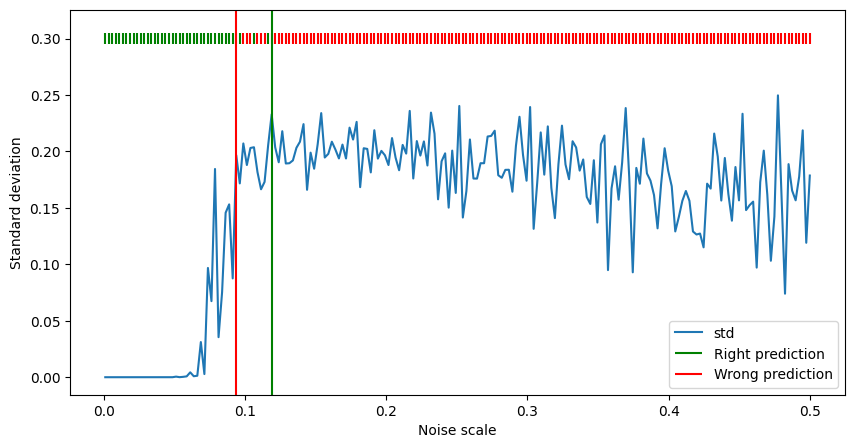

In [160]:
image, label = next(iter(test_loader))
image_batch_idx = 4
frog_img = image[image_batch_idx]
scales = np.linspace(0.001, 0.5, 200)
std_list = []
std_max = []
predicted_labels = []
for scale in scales:
  noised_img = frog_img + scale*torch.randn_like(image[image_batch_idx])
  samples = la.predictive_samples(noised_img.unsqueeze(0).cuda())
  probabilities = samples.mean(dim=0).squeeze(0).cpu().detach().numpy()
  std = samples.std(dim=0).squeeze(0).cpu().detach().numpy()
  std_list.append(std[np.argmax(probabilities)])
  predicted_labels.append(classes[np.argmax(probabilities)] == 'frog')
predicted_labels = np.array(predicted_labels)

plt.figure(figsize=(10,5))
plt.xlabel("Noise scale")
plt.ylabel("Standard deviation")
# plt.title("Evolution of the model standard deviation of the predicted class w.r.t the noise scale")
plt.legend(loc="lower right")

### Print the standard deviation
plt.plot(scales, std_list, label = "std")

### Print small vertical bars showing the right (green) and wrong (red) prediction
lineoffset = 0.3
plt.eventplot(scales[predicted_labels > 0], lineoffsets=lineoffset, linelengths=0.01, colors = 'green', label="Right prediction")
plt.eventplot(scales[predicted_labels == 0], lineoffsets=lineoffset, linelengths=0.01, colors = 'red', label ="Wrong prediction")

### Print long vertical bars to split the figure into 3 regimes : Correct prediction regime, random prediction regime, and wrong prediction regime
first_change = np.argmax(predicted_labels == 0)
last_change = predicted_labels.shape[0] - np.argmax(np.flip(predicted_labels > 0))
plt.axvline(x=scales[first_change], color = "red")
plt.axvline(x=scales[last_change], color = "green")
